In [1]:
# import package needed
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
import numpy as np
from ple.games.flappybird import FlappyBird
from ple import PLE

game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


In [3]:
game.getGameState()

{'player_y': 256,
 'player_vel': 0,
 'next_pipe_dist_to_player': 309.0,
 'next_pipe_top_y': 144,
 'next_pipe_bottom_y': 244,
 'next_next_pipe_dist_to_player': 453.0,
 'next_next_pipe_top_y': 160,
 'next_next_pipe_bottom_y': 260}

In [4]:
import math
import copy
from collections import defaultdict
MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5


class Agent:

    def __init__(self,
               bucket_range_per_feature,
               num_action,
               t=0,
               discount_factor=0.99):
        self.update_parameters(t)  # init explore rate and learning rate
        self.q_table = defaultdict(lambda: np.zeros(num_action))
        self.discount_factor = discount_factor
        self.num_action = num_action

        # how to discretize each feature in a state
        # the higher each value, less time to train but with worser performance
        # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        # epsilon-greedy
        state_idx = self.get_state_idx(state)
        if np.random.rand() < self.exploring_rate:
              action = np.random.choice(num_action)  # Select a random action
        else:
              action = np.argmax(
              self.q_table[state_idx])  # Select the action with the highest q
        return action

    def update_policy(self, state, action, reward, state_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Update Q_value using Q-learning update rule
        best_q = np.max(self.q_table[state_prime_idx])
        self.q_table[state_idx][action] += self.learning_rate * (
            reward + self.discount_factor * best_q - self.q_table[state_idx][action])

    def get_state_idx(self, state):
        # instead of using absolute position of pipe, use relative position
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # sort to make list converted from dict ordered in alphabet order
        state_key = [k for k, v in sorted(state.items())]

        # do bucketing to decrease state space to speed up training
        state_idx = []
        for key in state_key:
              state_idx.append(int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(MIN_EXPLORING_RATE,
                                  min(0.5, 0.99**((episode) / 30)))
        self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99
                                                        **((episode) / 30)))

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0

In [6]:
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps
    import moviepy.editor as mpy

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip

In [13]:
def demo(agent):
    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    agent.shutdown_explore()

    # the initial state
    state = game.getGameState()

    while not env.game_over():
        # select an action
        action = agent.select_action(state)

        # execute the action and get reward
        reward = env.act(env.getActionSet()[action])

        frames.append(env.getScreenRGB())

        # observe the result
        state_prime = game.getGameState()  # get next state

        # Setting up for the next iteration
        state = state_prime

    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
    display(clip.ipython_display(fps=60, autoplay=1, loop=1))


# Q-learning ( original version)

In [5]:
num_action = len(env.getActionSet())
bucket_range_per_feature = {
  'next_next_pipe_bottom_y': 40,
  'next_next_pipe_dist_to_player': 512,
  'next_next_pipe_top_y': 40,
  'next_pipe_bottom_y': 20,
  'next_pipe_dist_to_player': 20,
  'next_pipe_top_y': 20,
  'player_vel': 4,
  'player_y': 16
}
# init agent
agent = Agent(bucket_range_per_feature, num_action)

In [ ]:
from IPython.display import Image, display

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 35000
for episode in range(0, NUM_EPISODE):

    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        agent.shutdown_explore()

    # the initial state
    state = game.getGameState()
    cum_reward = 0  # cumulate reward for this episode
    t = 0

    while not env.game_over():

        # select an action
        action = agent.select_action(state)

        # execute the action and get reward
        reward = env.act(
            env.getActionSet()[action])  # reward = +1 when pass a pipe, -5 when die

        frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # observe the result
        state_prime = game.getGameState()  # get next state

        # update agent
        agent.update_policy(state, action, reward, state_prime)

        # Setting up for the next iteration
        state = state_prime
        t += 1

    # update exploring_rate and learning_rate
    agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode %d finished after %f time steps" % (episode, t))
        print("cumulated reward: %f" % cum_reward)
        print("exploring rate %f" % agent.exploring_rate)
        print("learning rate %f" % agent.learning_rate)
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(agent.exploring_rate)
        learning_rates.append(agent.learning_rate)
        lifetime_per_epoch.append(t)

    # for every 5000 episode, record an animation
    if episode % show_gif_every_episode == 0:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))

#### I clear the ouput of Q-learning training before I saw the announcement because the file is getting too large for me to upload to ilms QQ

In [50]:
demo(agent)

100%|█████████▉| 743/744 [00:02<00:00, 294.52it/s]


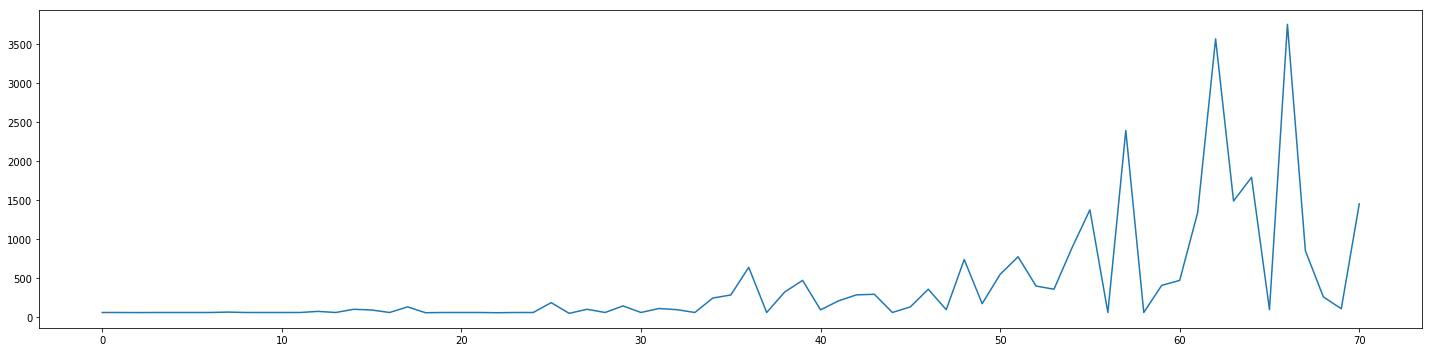

In [9]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
plt.show()

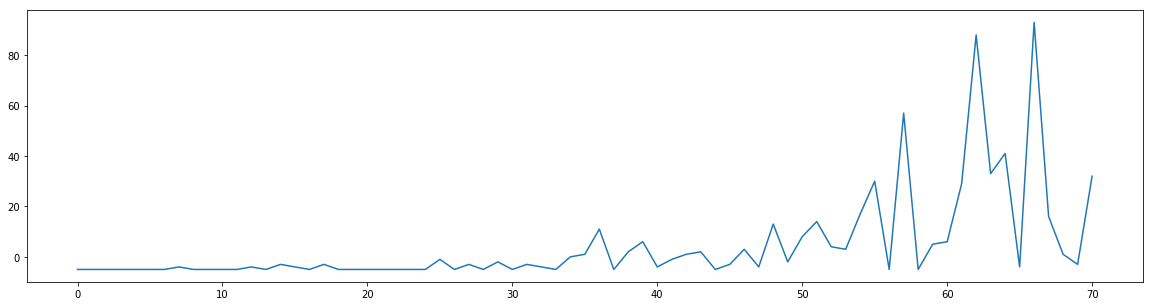

In [10]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()

# SARSA

In [11]:
class Agent_SARSA:

    def __init__(self,
               bucket_range_per_feature,
               num_action,
               t=0,
               discount_factor=0.99):
        self.update_parameters(t)  # init explore rate and learning rate
        self.q_table = defaultdict(lambda: np.zeros(num_action))
        self.discount_factor = discount_factor
        self.num_action = num_action

        # how to discretize each feature in a state
        # the higher each value, less time to train but with worser performance
        # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        # epsilon-greedy
        state_idx = self.get_state_idx(state)
        if np.random.rand() < self.exploring_rate:
              action = np.random.choice(num_action)  # Select a random action
        else:
              action = np.argmax(
              self.q_table[state_idx])  # Select the action with the highest q
        return action

    def update_policy(self, state, action, reward, state_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Update Q_value using SARSA update rule
        action_prime = self.select_action(state_prime)
        expected_q = self.q_table[state_prime_idx][action_prime]
        self.q_table[state_idx][action] += self.learning_rate * (
            reward + self.discount_factor * expected_q - self.q_table[state_idx][action])

    def get_state_idx(self, state):
        # instead of using absolute position of pipe, use relative position
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # sort to make list converted from dict ordered in alphabet order
        state_key = [k for k, v in sorted(state.items())]

        # do bucketing to decrease state space to speed up training
        state_idx = []
        for key in state_key:
              state_idx.append(int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(MIN_EXPLORING_RATE,
                                  min(0.5, 0.99**((episode) / 30)))
        self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99
                                                        **((episode) / 30)))

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0

In [12]:
# init agent
agent_s = Agent_SARSA(bucket_range_per_feature, num_action)

In [14]:
s_reward_per_epoch = []
s_lifetime_per_epoch = []
s_exploring_rates = []
s_learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 35000
for episode in range(0, NUM_EPISODE):

    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        agent_s.shutdown_explore()

    # the initial state
    state = game.getGameState()
    cum_reward = 0  # cumulate reward for this episode
    t = 0

    while not env.game_over():

        # select an action
        action = agent_s.select_action(state)

        # execute the action and get reward
        reward = env.act(
            env.getActionSet()[action])  # reward = +1 when pass a pipe, -5 when die

        frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # observe the result
        state_prime = game.getGameState()  # get next state

        # update agent
        agent_s.update_policy(state, action, reward, state_prime)

        # Setting up for the next iteration
        state = state_prime
        t += 1

    # update exploring_rate and learning_rate
    agent_s.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode %d finished after %f time steps" % (episode, t))
        print("cumulated reward: %f" % cum_reward)
        print("exploring rate %f" % agent_s.exploring_rate)
        print("learning rate %f" % agent_s.learning_rate)
        s_reward_per_epoch.append(cum_reward)
        s_exploring_rates.append(agent_s.exploring_rate)
        s_learning_rates.append(agent_s.learning_rate)
        s_lifetime_per_epoch.append(t)

    # for every 5000 episode, record an animation
    if episode % show_gif_every_episode == 0:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))

 38%|███▊      | 24/64 [00:00<00:00, 233.74it/s]

Episode 0 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
len frames: 63


 98%|█████████▊| 63/64 [00:00<00:00, 268.58it/s]


Episode 500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 1000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 1500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 2000 finished after 59.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 2500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.432779
learning rate 0.500000
Episode 3000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.366032
learning rate 0.500000
Episode 3500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.309580
learning rate 0.500000
Episode 4000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.261834
learning rate 0.500000
Episode 4

 39%|███▉      | 25/64 [00:00<00:00, 245.87it/s]

Episode 5000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.187298
learning rate 0.500000
len frames: 63


 98%|█████████▊| 63/64 [00:00<00:00, 275.36it/s]


Episode 5500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.158411
learning rate 0.500000
Episode 6000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.133980
learning rate 0.500000
Episode 6500 finished after 104.000000 time steps
cumulated reward: -3.000000
exploring rate 0.113316
learning rate 0.500000
Episode 7000 finished after 45.000000 time steps
cumulated reward: -5.000000
exploring rate 0.095840
learning rate 0.500000
Episode 7500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.081059
learning rate 0.500000
Episode 8000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.068557
learning rate 0.500000
Episode 8500 finished after 76.000000 time steps
cumulated reward: -4.000000
exploring rate 0.057984
learning rate 0.500000
Episode 9000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.049041
learning rate 0.500000
Episode

 25%|██▌       | 25/100 [00:00<00:00, 248.30it/s]

Episode 10000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.035080
learning rate 0.500000
len frames: 99


 99%|█████████▉| 99/100 [00:00<00:00, 292.27it/s]


Episode 10500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.029670
learning rate 0.500000
Episode 11000 finished after 70.000000 time steps
cumulated reward: -4.000000
exploring rate 0.025094
learning rate 0.500000
Episode 11500 finished after 77.000000 time steps
cumulated reward: -4.000000
exploring rate 0.021224
learning rate 0.500000
Episode 12000 finished after 175.000000 time steps
cumulated reward: -2.000000
exploring rate 0.017951
learning rate 0.500000
Episode 12500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.015182
learning rate 0.500000
Episode 13000 finished after 77.000000 time steps
cumulated reward: -4.000000
exploring rate 0.012841
learning rate 0.500000
Episode 13500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010860
learning rate 0.500000
Episode 14000 finished after 175.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500

 21%|██        | 28/136 [00:00<00:00, 275.45it/s]

Episode 15000 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
len frames: 135


 99%|█████████▉| 135/136 [00:00<00:00, 316.34it/s]


Episode 15500 finished after 72.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 16000 finished after 437.000000 time steps
cumulated reward: 5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 16500 finished after 183.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 17000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 17500 finished after 247.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 18000 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 18500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 19000 finished after 360.000000 time steps
cumulated reward: 3.000000
exploring rate 0.010000
learning rate 0.5000

  5%|▌         | 25/475 [00:00<00:01, 246.31it/s]

Episode 20000 finished after 473.000000 time steps
cumulated reward: 6.000000
exploring rate 0.010000
learning rate 0.500000
len frames: 474


100%|█████████▉| 474/475 [00:01<00:00, 313.39it/s]


Episode 20500 finished after 564.000000 time steps
cumulated reward: 9.000000
exploring rate 0.010000
learning rate 0.500000
Episode 21000 finished after 212.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 21500 finished after 140.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 22000 finished after 211.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 22500 finished after 175.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 23000 finished after 250.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 23500 finished after 69.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 24000 finished after 926.000000 time steps
cumulated reward: 18.000000
exploring rate 0.010000
learning rate 0.50

  9%|▉         | 12/136 [00:00<00:01, 117.90it/s]

Episode 25000 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
len frames: 135


 99%|█████████▉| 135/136 [00:00<00:00, 277.69it/s]


Episode 25500 finished after 1603.000000 time steps
cumulated reward: 36.000000
exploring rate 0.010000
learning rate 0.500000
Episode 26000 finished after 2462.000000 time steps
cumulated reward: 59.000000
exploring rate 0.010000
learning rate 0.500000
Episode 26500 finished after 401.000000 time steps
cumulated reward: 4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 27000 finished after 65.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 27500 finished after 247.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 28000 finished after 1424.000000 time steps
cumulated reward: 32.000000
exploring rate 0.010000
learning rate 0.500000
Episode 28500 finished after 175.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 29000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.

 10%|█         | 9/89 [00:00<00:00, 89.93it/s]

Episode 30000 finished after 87.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
len frames: 88


 99%|█████████▉| 88/89 [00:00<00:00, 251.68it/s]


Episode 30500 finished after 2019.000000 time steps
cumulated reward: 47.000000
exploring rate 0.010000
learning rate 0.500000
Episode 31000 finished after 211.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 31500 finished after 2366.000000 time steps
cumulated reward: 57.000000
exploring rate 0.010000
learning rate 0.500000
Episode 32000 finished after 226.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 32500 finished after 189.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 33000 finished after 1354.000000 time steps
cumulated reward: 30.000000
exploring rate 0.010000
learning rate 0.500000
Episode 33500 finished after 139.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 34000 finished after 1911.000000 time steps
cumulated reward: 45.000000
exploring rate 0.010000
learning rat

In [16]:
demo(agent_s)

100%|█████████▉| 1116/1117 [00:03<00:00, 296.35it/s]


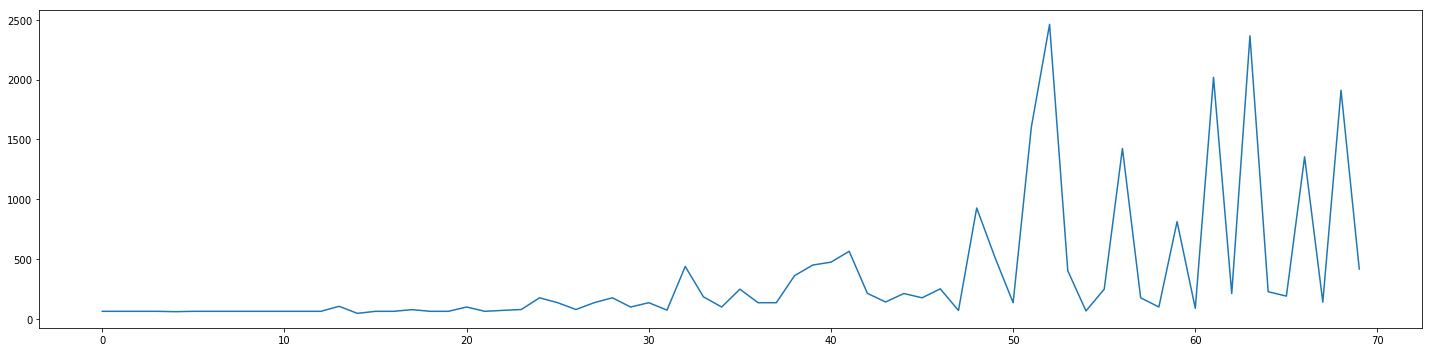

In [17]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(s_lifetime_per_epoch)), s_lifetime_per_epoch)
fig.tight_layout()
plt.show()

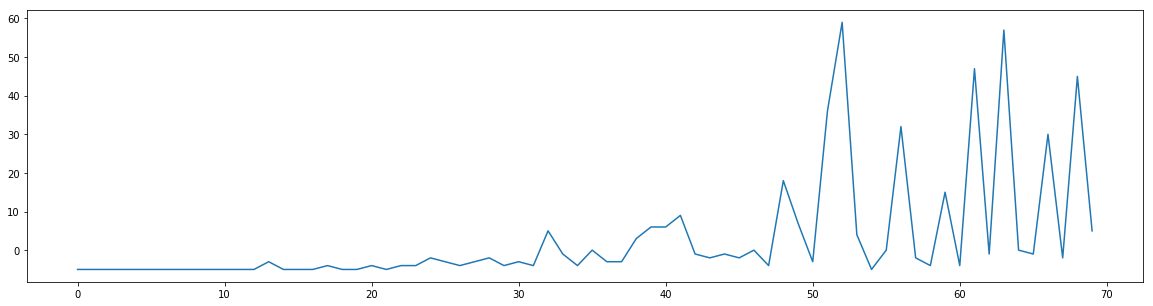

In [18]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(s_reward_per_epoch)), s_reward_per_epoch)
plt.show()

# Report

The key different of Q-learning and SARSA is that Q-learning is off-policy while SARSA is on-policy algorithm. That is, Q-learning use the best possibility of next sate to calculate and update policy, while SARSA predict next state by action based on current policy to update and chase Qπ.
<br><br>
Lets compare the result:

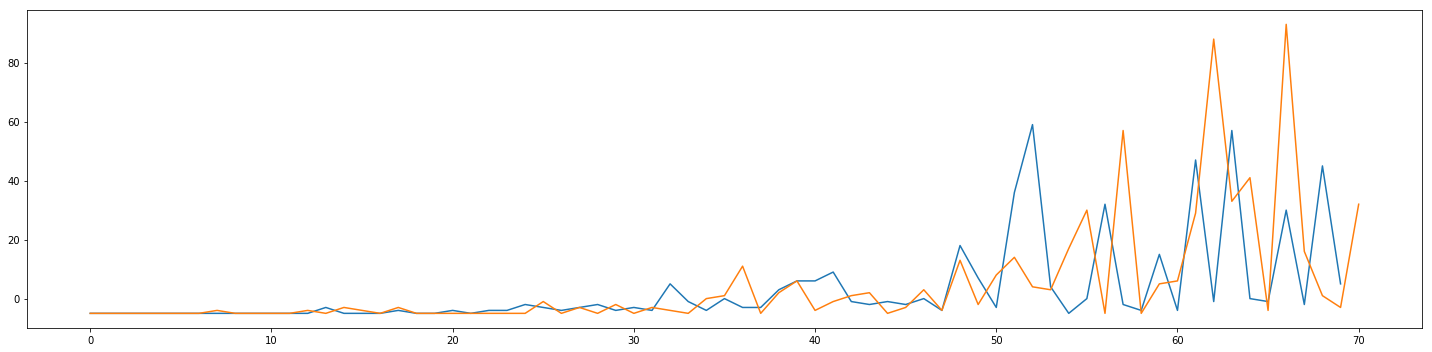

orange: Q-learning, blue : SARSA


In [40]:
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(s_reward_per_epoch)), s_reward_per_epoch)
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
fig.tight_layout()
plt.show()
print("orange: Q-learning, blue : SARSA")

Here I use reward instead of life time because I think it could reflect the result better.
#### since both update policy can't start converge until episode 15,000 (30*500), let's take closer look about the episodes after 15,000

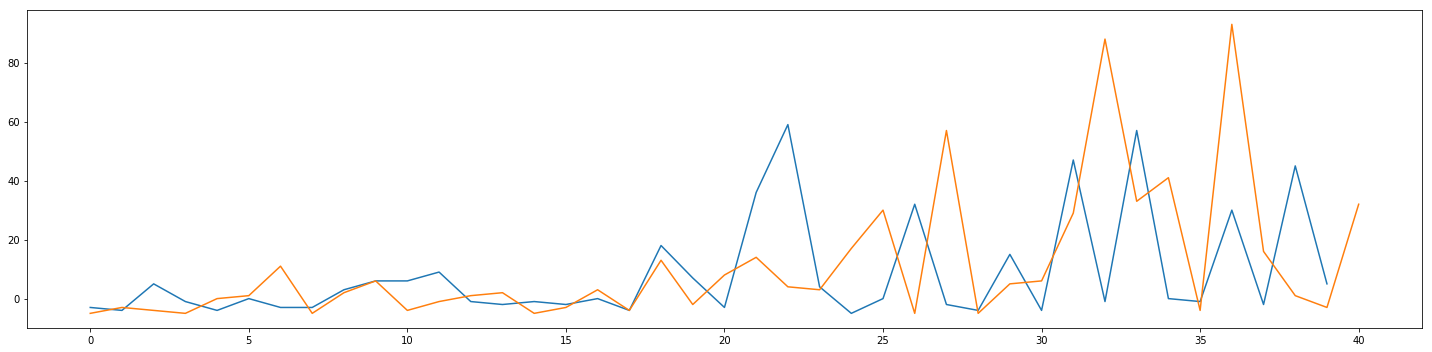

orange: Q-learning, blue : SARSA


In [42]:
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(s_reward_per_epoch[30:])), s_reward_per_epoch[30:])
plt.plot(range(len(reward_per_epoch[30:])), reward_per_epoch[30:])
fig.tight_layout()
plt.show()
print("orange: Q-learning, blue : SARSA")

In [45]:
print("--- Q-learning ---")
print("mean : ", np.mean(reward_per_epoch[30:]))
print("median : ", np.median(reward_per_epoch[30:]))
print("best : ", np.max(reward_per_epoch[30:]))
print("worst : ", np.min(reward_per_epoch[30:]))
print("standard variance : ", np.std(reward_per_epoch[30:]))
print("positve : ", len( np.where(np.asarray(reward_per_epoch[30:])>0)[0] ))
print("--- SARSA ---")
print("mean : ", np.mean(s_reward_per_epoch[30:]))
print("median : ", np.median(s_reward_per_epoch[30:]))
print("best : ", np.max(s_reward_per_epoch[30:]))
print("worst : ", np.min(s_reward_per_epoch[30:]))
print("standard variance : ", np.std(s_reward_per_epoch[30:]))
print("positve : ", len( np.where(np.asarray(s_reward_per_epoch[30:])>0)[0] ))

--- Q-learning ---
mean :  11.170731707317072
median :  2.0
best :  93.0
worst :  -5.0
standard variance :  22.922884974674663
positve :  25
--- SARSA ---
mean :  8.35
median :  0.0
best :  59.0
worst :  -5.0
standard variance :  17.594814577028085
positve :  17


With more aggressive and greedy policy, Q-learning has much higher momentum to keep getting better result. On the other hand, though SARSA has slightly more stable result, the 'ceilling' occurs around 25,000 episode. Therfore, in my opinion, Q-learning is the better approach. Maybe could adjust learning rate or other hyperparameters for more stable training path.